# Optimisation: L-BFGS

This example shows you how to run a global optimisation with [L-BFGS](http://pints.readthedocs.io/en/latest/optimisers/lbfgs.html).

For a more elaborate example of an optimisation, see: [basic optimisation example](./first-example.ipynb).

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#specifing a simple model for LBFGS line search trial

# dzdt = ax^2 +by^2
# dz/dxdt = 2ax
# dz/dydt = 2by
# starting conditions z=0, y=0, x=0
# x and y increase by 1 in each step?

class easyProblem(pints.ForwardModelS1):
    """
    A model with parameters of a similar magantuide
    """

    def __init__(self):
        super(easyProblem, self).__init__()

    def n_parameters(self):
            return 2
    def n_outputs(self):
            return 1

    def _simulate(self, parameters, times, senstivities = False):

        # unpacking parameters
        a = parameters[0]
        b = parameters[1]
        #ax^2 +by^2 where x= sin(times) and y=cos(time)
        time_dim = len(times)
        time_step = float(times[1])
        x = np.sin(times)
        y = np.cos(times)
        dzdt = a*np.square(x) + b*np.square(y)
        if senstivities is True:

            # creating senetivity matrix
            sen = np.zeros((time_dim,2,3))
            for i, xi in enumerate(x):
                old_sen = sen[i,:,:]

                if i < time_dim:
                    # df/dtheta
                    dfdtheta = np.asarray([[0,0],
                                        [0,0],
                                        [xi**2, y[i]**2]])
                    # jacobian df/du
                    Jac = np.array([[0,1,0],
                                    [-1,0,0],
                                    [2*a*xi, 2*b*y[i], 0]])
                    temp = np.matmul(old_sen, np.transpose(Jac)) + np.transpose(dfdtheta)
                    new_sen = temp*time_step + old_sen

                    # assigning the new sentivity to the right place in the senstivity array
                    sen[i,:,:] = new_sen

            return (dzdt, sen[:,:,-1])

        else:
            return dzdt
    
    def simulate(self, parameters, times):
        return self._simulate(parameters, times, senstivities = False)

    def simulateS1(self, parameters, times):
        return self._simulate(parameters, times, senstivities = True)

    def suggested_parameters(self):
        """suggested parameters for the model [a, b]"""
        return [3, 9]
    def suggested_times(self):
        """suggested times for the model range 0 to 10"""
        return np.linspace(0, 10, num=100000)

In [3]:
# making some toy data
model = easyProblem()
times = model.suggested_times()
real_parameters = model.suggested_parameters()
output = model.simulateS1(real_parameters, times)#
values = output[0]
sensetivities = output[1]

## Using the Hager-Zhang linesearch implimentation of the LBFGS optimser

Minimising error measure
Using Broyden-Fletcher-Goldfarb-Shanno (BFGS)
Running in sequential mode.

Hessian updates:  0  line steps:  0  propose alpha:  0.001  propose points:  [0.01 0.01]
Iter. Eval. Best      Time m:s
0     1      1.42e+07   0:01.9
alpha_initial:  1.2626003255377118e-06
Number of accepted steps:  0
step size of alpha accepted:  0.10154474127440917
updating Hessian and changing newton direction

Hessian updates:  1  line steps:  0  propose alpha:  0.10154474127440917  propose points:  [4.34929732 8.05250872]
1     2      1.01e+07   0:22.8
alpha_initial:  0.20308948254881834
Number of accepted steps:  1
step size of alpha accepted:  0.18279326950513297
updating Hessian and changing newton direction

Hessian updates:  2  line steps:  0  propose alpha:  0.18279326950513297  propose points:  [2.86351878 8.75197834]
2     3      9996514    0:29.6
alpha_initial:  0.36558653901026594
Number of accepted steps:  2
step size of alpha accepted:  0.06556133817314082
updating Hess

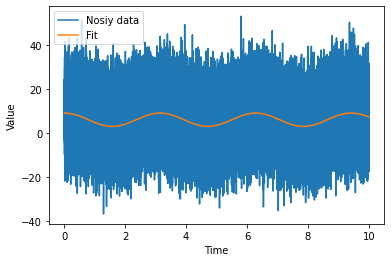

In [5]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries
boundaries = pints.RectangularBoundaries([0, 0], [20, 20])

# Perform an optimization with boundaries and hints
x0 = 0.01, 0.01
opt = pints.OptimisationController(
    score,
    x0,
    method=pints.LBFGS
)
opt.set_max_unchanged_iterations(10)
opt.set_max_iterations(200)
found_parameters, found_value = opt.run()

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

# Show quality of fit
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(times, values, label='Nosiy data')
plt.plot(times, problem.evaluate(found_parameters), label='Fit')
plt.legend()
plt.show()


## Using the CMA-ES to solve the same problem

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      1.12e+07   0:00.1
1     12     1.07e+07   0:00.1
2     18     1.04e+07   0:00.2
3     24     1.02e+07   0:00.2
20    126    9993283    0:00.7
40    246    9993282    0:01.2
60    366    9993282    0:01.8
80    486    9993282    0:02.3
100   606    9993282    0:02.8
120   726    9993282    0:03.3
140   846    9993282    0:03.9
160   966    9993282    0:04.4
180   1086   9993282    0:04.9
200   1206   9993282    0:05.4
220   1326   9993282    0:05.8
240   1446   9993282    0:06.3
260   1566   9993282    0:06.7
272   1632   9993282    0:06.9
Halting: No significant change for 200 iterations.
Score at true solution: 
9993481.362921719
Found solution:          True parameters:
 2.92147774048697517e+00     3.00000000000000000e+00
 9.01371505503933079e+00     9.00000000000000000e+00


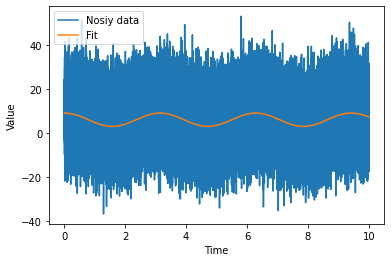

In [4]:
# fiiting using cmaes to the toy data

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries
boundaries = pints.RectangularBoundaries([0, 0], [20, 20])

# Perform an optimization with boundaries and hints
x0 = 0.01, 0.01
#sigma0 = [0.01, 100]
found_parameters, found_value = pints.optimise(
    score,
    x0,
    boundaries = boundaries,
    method=pints.CMAES
    )

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

# Show quality of fit
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(times, values, label='Nosiy data')
plt.plot(times, problem.evaluate(found_parameters), label='Fit')
plt.legend()
plt.show()

